# 1. Setup

In [1]:
# ---------------------------------------------------------------
# STEP 1: Install stable package versions.
# ---------------------------------------------------------------
%pip install -q "torch>=2.2.0" "transformers>=4.57.0" "datasets>=2.19.0" \
               "evaluate>=0.4.2" "peft>=0.11.1" scikit-learn matplotlib pandas psutil

Note: you may need to restart the kernel to use updated packages.


# 2. Imports and Profiling Helpers

In [2]:
# ---------------------------------------------------------------
# STEP 2: Imports, reproducibility, and device setup.
# ---------------------------------------------------------------
import os, time, itertools, random, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os, time, threading, psutil, contextlib
from datasets import load_dataset, DatasetDict
import evaluate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

from peft import LoraConfig, get_peft_model

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Prefer Apple's Metal (MPS); fallback to CPU if unavailable
DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", DEVICE)


# ---------------------------------------------------------------
# Profiling helpers: wall-clock time + peak memory
# - On CUDA: we record true VRAM (max_memory_allocated)
# - On MPS/CPU: we record process RSS peak (GB) via psutil sampler
# ---------------------------------------------------------------

def _rss_sampler(stop_event, interval, peaks_list):
    """Background sampler to track process RSS and record the peak."""
    proc = psutil.Process(os.getpid())
    peak = 0
    while not stop_event.is_set():
        try:
            rss = proc.memory_info().rss  # bytes
            if rss > peak:
                peak = rss
        except Exception:
            pass
        time.sleep(interval)
    peaks_list.append(peak)

@contextlib.contextmanager
def profile_run(device: str, sample_interval: float = 0.25):
    """
    Context manager that measures wall time and peak memory.
    Yields a dict that gets filled with: time_s, peak_mem_gb, (optionally) peak_vram_gb.
    """
    stats = {"time_s": None, "peak_mem_gb": None, "peak_vram_gb": None}
    stop_evt = threading.Event()
    peaks = []

    # CUDA VRAM peak reset
    if torch.cuda.is_available() and device.startswith("cuda"):
        torch.cuda.reset_peak_memory_stats()

    # Start RSS sampler for all backends
    sampler = threading.Thread(target=_rss_sampler, args=(stop_evt, sample_interval, peaks), daemon=True)
    sampler.start()

    t0 = time.time()
    try:
        yield stats
    finally:
        # Synchronize device to flush kernels before stopping timers/memory reads
        try:
            if device.startswith("cuda"):
                torch.cuda.synchronize()
            elif device == "mps":
                torch.mps.synchronize()
        except Exception:
            pass

        stats["time_s"] = time.time() - t0

        # Stop RSS sampler and compute peak RSS (GB)
        stop_evt.set()
        sampler.join(timeout=2)
        peak_rss = max(peaks) if peaks else 0
        stats["peak_mem_gb"] = peak_rss / (1024**3)

        # CUDA VRAM (GB)
        if torch.cuda.is_available() and device.startswith("cuda"):
            stats["peak_vram_gb"] = torch.cuda.max_memory_allocated() / (1024**3)


✅ Using device: mps


# 3. Load Dataset

In [3]:
# ---------------------------------------------------------------
# STEP 3: Load IMDb dataset and create a validation split.
# IMDb: ~25k train, ~25k test. Split 10% of train for validation.
# Labels: 0 = negative, 1 = positive (binary classification).
# ---------------------------------------------------------------
raw = load_dataset("imdb")

# Create validation split (10% of original train)
split = raw["train"].train_test_split(test_size=0.1, seed=SEED)
dataset = DatasetDict({
    "train": split["train"],
    "validation": split["test"],
    "test": raw["test"]
})
dataset

# ---------------------------------------------------------------
# STEP 3b: Quick preview and label distribution.
# ---------------------------------------------------------------
label_map = {0: "negative", 1: "positive"}

for i in range(3):
    ex = dataset["train"][i]
    print(f"\nExample {i+1}")
    print("Text:", ex["text"][:300].replace("\n"," "), "...")
    print("Label:", label_map[int(ex["label"])])

def counts(labels):
    arr = np.array(labels)
    return {0:int((arr==0).sum()), 1:int((arr==1).sum())}

print("\nLabel distribution (train):", counts(dataset["train"]["label"]))
print("Label distribution (val):   ", counts(dataset["validation"]["label"]))
print("Label distribution (test):  ", counts(dataset["test"]["label"]))

# Take a smaller subset for local compute limitations
dataset["train"] = dataset["train"].shuffle(seed=SEED).select(range(4000))
dataset["validation"] = dataset["validation"].shuffle(seed=SEED).select(range(1000))
dataset["test"] = dataset["test"].shuffle(seed=SEED).select(range(1000))


Example 1
Text: With these people faking so many shots, using old footage, and gassing animals to get them out, not to mention that some of the scenes were filmed on a created set with actors, what's to believe? Old film of countries is nice, but the animal abuse and degradation of natives is painful to watch in th ...
Label: negative

Example 2
Text: I don't know the stars, or modern Chinese teenage music - but I do know a thoroughly entertaining movie when I see one.<br /><br />Kung Fu Dunk is pure Hollywood in its values - it's played for laughs, for love, and is a great blend of Kung Fu and basketball.<br /><br />Everybody looks like they had ...
Label: positive

Example 3
Text: Having lived in Ontario my whole life, in the same town that Marlene Moore grew up in, I've heard stories of her from my parents, grandparents and family members. So when I found out that they would be filming a movie about her, and that the beginning would be shot on my street, and her house quite  ...
La

# 4. Tokenization

In [4]:
# ---------------------------------------------------------------
# STEP 4: Tokenize reviews for DistilBERT.
# - IMDb reviews can be long; max_length=256 balances speed & quality.
# - Padding to max_length stabilizes batching on MPS.
# ---------------------------------------------------------------
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

tokenized = dataset.map(tokenize, batched=True).remove_columns(["text"])
tokenized.set_format("torch")
tokenized

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

# 5. Metrics (Accuracy + F1)

In [5]:
# ---------------------------------------------------------------
# STEP 5: Define evaluation metrics.
# - Accuracy: overall correctness.
# - F1 (weighted): balances precision/recall and accounts for class imbalance.
# ---------------------------------------------------------------
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1  = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": acc, "f1": f1}


# 6. Hyperparameter Tuning (Full)

In [6]:
# ---------------------------------------------------------------
# STEP 6: Hyperparameter tuning (validation) for Full Fine-Tuning.
# Grid: learning_rate x batch_size x epochs.
# ---------------------------------------------------------------
param_grid_full = {
    "learning_rate": [2e-5, 3e-5, 5e-5],
    "per_device_train_batch_size": [8, 16],
    "num_train_epochs": [2, 3],
}

results_full = []
for lr in param_grid_full["learning_rate"]:
    for bs in param_grid_full["per_device_train_batch_size"]:
        for ep in param_grid_full["num_train_epochs"]:
            print(f"\n⚙️ Full-FT trial  lr={lr}, bs={bs}, epochs={ep}")
            # use single shared output directory and measure time + memory
            args = TrainingArguments(
                output_dir="./temp_tuning",       # shared temp folder
                overwrite_output_dir=True,        # overwrite each run
                eval_strategy="epoch",
                save_strategy="no",               # no checkpoint saving
                logging_strategy="no",           
                learning_rate=lr,
                per_device_train_batch_size=bs,
                per_device_eval_batch_size=bs*2,
                num_train_epochs=ep,
                weight_decay=0.01,
                fp16=False, bf16=False,
                report_to="none",
                use_mps_device=True,
            )
            
            model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
            trainer = Trainer(
                model=model,
                args=args,
                train_dataset=tokenized["train"],
                eval_dataset=tokenized["validation"],
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,
            )
            
            # --- efficiency tracking ---
            with profile_run(DEVICE) as prof:
                trainer.train()
            
            # collect validation results + profiling info
            val = trainer.evaluate()
            val.update({
                "lr": lr,
                "bs": bs,
                "ep": ep,
                "time_s": prof["time_s"],
                "peak_mem_gb": prof["peak_mem_gb"],
            })
            if prof["peak_vram_gb"] is not None:
                val["peak_vram_gb"] = prof["peak_vram_gb"]
            
            results_full.append(val)


df_full = pd.DataFrame(results_full).sort_values("eval_f1", ascending=False)
display(df_full)
best_full = df_full.iloc[0].to_dict()
print("🏆 Best Full-FT hyperparams:", best_full)


⚙️ Full-FT trial  lr=2e-05, bs=8, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.307230,0.887000,0.887029
2,No log,0.361740,0.889000,0.889023


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ Full-FT trial  lr=2e-05, bs=8, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.310849,0.897000,0.897018
2,No log,0.401553,0.887000,0.886946
3,No log,0.467366,0.890000,0.890000


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ Full-FT trial  lr=2e-05, bs=16, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.292962,0.882000,0.881821
2,No log,0.284302,0.899000,0.898981


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ Full-FT trial  lr=2e-05, bs=16, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.293588,0.873000,0.872525
2,No log,0.296554,0.894000,0.893840
3,No log,0.350356,0.892000,0.891965


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ Full-FT trial  lr=3e-05, bs=8, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.296314,0.891000,0.890980
2,No log,0.386979,0.888000,0.888025


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ Full-FT trial  lr=3e-05, bs=8, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.337037,0.882000,0.881859
2,No log,0.446930,0.886000,0.885926
3,No log,0.535479,0.881000,0.881004


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ Full-FT trial  lr=3e-05, bs=16, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.303482,0.881000,0.880460
2,No log,0.280709,0.894000,0.894020


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ Full-FT trial  lr=3e-05, bs=16, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.299755,0.878000,0.877725
2,No log,0.318696,0.888000,0.887964
3,No log,0.405706,0.886000,0.885940


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ Full-FT trial  lr=5e-05, bs=8, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.339800,0.886000,0.885963
2,No log,0.411994,0.881000,0.881010


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ Full-FT trial  lr=5e-05, bs=8, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.437242,0.873000,0.872459
2,No log,0.534273,0.865000,0.863904
3,No log,0.540355,0.885000,0.885027


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ Full-FT trial  lr=5e-05, bs=16, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.316807,0.875000,0.874624
2,No log,0.333684,0.892000,0.892027


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ Full-FT trial  lr=5e-05, bs=16, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/266861649.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213/

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.302972,0.876000,0.875852
2,No log,0.347936,0.885000,0.884836
3,No log,0.447484,0.890000,0.889984


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,lr,bs,ep,time_s,peak_mem_gb
2,0.284302,0.899,0.898981,36.1061,27.696,0.886,2.0,0.00002,16,2,795.746136,1.080231
6,0.280709,0.894,0.894020,22.2044,45.036,1.441,2.0,0.00003,16,2,676.475052,0.765335
10,0.333684,0.892,0.892027,19.4208,51.491,1.648,2.0,0.00005,16,2,624.410175,0.507370
3,0.350356,0.892,0.891965,36.5289,27.376,0.876,3.0,0.00002,16,3,1899.413486,0.671127
1,0.467366,0.890,0.890000,25.1728,39.725,2.503,3.0,0.00002,8,3,1172.162691,0.900558
11,0.447484,0.890,0.889984,19.9550,50.113,1.604,3.0,0.00005,16,3,972.214619,0.472687
0,0.361740,0.889,0.889023,31.4723,31.774,2.002,2.0,0.00002,8,2,816.651853,0.950211
4,0.386979,0.888,0.888025,29.6190,33.762,2.127,2.0,0.00003,8,2,980.245010,0.689285
7,0.405706,0.886,0.885940,20.1420,49.647,1.589,3.0,0.00003,16,3,973.883140,0.689651
9,0.540355,0.885,0.885027,20.5453,48.673,3.066,3.0,0.00005,8,3,1091.362624,0.492371


🏆 Best Full-FT hyperparams: {'eval_loss': 0.2843015193939209, 'eval_accuracy': 0.899, 'eval_f1': 0.8989812893851683, 'eval_runtime': 36.1061, 'eval_samples_per_second': 27.696, 'eval_steps_per_second': 0.886, 'epoch': 2.0, 'lr': 2e-05, 'bs': 16.0, 'ep': 2.0, 'time_s': 795.7461359500885, 'peak_mem_gb': 1.080230712890625}


# 7. Hyperparameter Tuning (LoRa)

In [7]:
# ---------------------------------------------------------------
# STEP 7: Hyperparameter tuning (validation) for LoRA (PEFT).
# ---------------------------------------------------------------
param_grid_lora = {
    "learning_rate": [1e-4, 2e-4, 5e-4],
    "per_device_train_batch_size": [8, 16],
    "num_train_epochs": [2, 3],
}

results_lora = []
for lr in param_grid_lora["learning_rate"]:
    for bs in param_grid_lora["per_device_train_batch_size"]:
        for ep in param_grid_lora["num_train_epochs"]:
            print(f"\n⚙️ LoRA trial  lr={lr}, bs={bs}, epochs={ep}")

            args = TrainingArguments(
                output_dir="./temp_tuning",        
                overwrite_output_dir=True,         
                eval_strategy="epoch",
                save_strategy="no",                # don't save checkpoints
                logging_strategy="no",            
                learning_rate=lr,
                per_device_train_batch_size=bs,
                per_device_eval_batch_size=bs*2,
                num_train_epochs=ep,
                weight_decay=0.01,
                fp16=False, bf16=False,           
                report_to="none",
                use_mps_device=True,               # prefer Apple GPU
            )
            
            base = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
            lora_cfg = LoraConfig(
                r=8, lora_alpha=16, target_modules=["q_lin","v_lin"], lora_dropout=0.1,
                bias="none", task_type="SEQ_CLS"
            )
            model = get_peft_model(base, lora_cfg)
            
            trainer = Trainer(
                model=model,
                args=args,
                train_dataset=tokenized["train"],
                eval_dataset=tokenized["validation"],
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,
            )
            
            # --- efficiency tracking (time + memory) ---
            with profile_run(DEVICE) as prof:
                trainer.train()
            
            # collect validation results + profiling info
            val = trainer.evaluate()
            val.update({
                "lr": lr,
                "bs": bs,
                "ep": ep,
                "time_s": prof["time_s"],
                "peak_mem_gb": prof["peak_mem_gb"],
            })
            if prof["peak_vram_gb"] is not None:      # will be None on MPS, set on CUDA
                val["peak_vram_gb"] = prof["peak_vram_gb"]
            
            results_lora.append(val)


df_lora = pd.DataFrame(results_lora).sort_values("eval_f1", ascending=False)
display(df_lora)
best_lora = df_lora.iloc[0].to_dict()
print("🏆 Best LoRA hyperparams:", best_lora)


⚙️ LoRA trial  lr=0.0001, bs=8, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.316072,0.876000,0.876000
2,No log,0.301643,0.882000,0.882007


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ LoRA trial  lr=0.0001, bs=8, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.309768,0.877000,0.877017
2,No log,0.299738,0.885000,0.884904
3,No log,0.302045,0.883000,0.882988


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ LoRA trial  lr=0.0001, bs=16, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.331601,0.869000,0.868873
2,No log,0.306138,0.876000,0.876019


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ LoRA trial  lr=0.0001, bs=16, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.327933,0.865000,0.864850
2,No log,0.290512,0.885000,0.884969
3,No log,0.287599,0.886000,0.886000


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ LoRA trial  lr=0.0002, bs=8, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.310403,0.876000,0.876032
2,No log,0.296096,0.885000,0.885004


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ LoRA trial  lr=0.0002, bs=8, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.304594,0.875000,0.875031
2,No log,0.306029,0.883000,0.882852
3,No log,0.315349,0.887000,0.886958


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ LoRA trial  lr=0.0002, bs=16, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.314020,0.872000,0.871946
2,No log,0.285439,0.885000,0.885028


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ LoRA trial  lr=0.0002, bs=16, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.311999,0.874000,0.873947
2,No log,0.278009,0.889000,0.888979
3,No log,0.279422,0.892000,0.891993


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ LoRA trial  lr=0.0005, bs=8, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.311152,0.877000,0.877031
2,No log,0.290059,0.887000,0.887010


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ LoRA trial  lr=0.0005, bs=8, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.302532,0.877000,0.877028
2,No log,0.313528,0.886000,0.885846
3,No log,0.332749,0.888000,0.887974


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ LoRA trial  lr=0.0005, bs=16, epochs=2


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.301066,0.876000,0.876030
2,No log,0.272578,0.889000,0.889019


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



⚙️ LoRA trial  lr=0.0005, bs=16, epochs=3


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1283825550.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fongkangwei/nus/ay25_26/dsa4213

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.290666,0.885000,0.885004
2,No log,0.271040,0.894000,0.893966
3,No log,0.279452,0.898000,0.897985


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,lr,bs,ep,time_s,peak_mem_gb
11,0.279452,0.898,0.897985,27.1408,36.845,1.179,3.0,0.0005,16,3,1184.586756,0.485428
7,0.279422,0.892,0.891993,31.2565,31.993,1.024,3.0,0.0002,16,3,929.191971,0.461761
10,0.272578,0.889,0.889019,40.6278,24.614,0.788,2.0,0.0005,16,2,647.679255,0.483154
9,0.332749,0.888,0.887974,31.7452,31.501,1.985,3.0,0.0005,8,3,951.619254,0.495331
8,0.290059,0.887,0.887010,28.4719,35.122,2.213,2.0,0.0005,8,2,629.560728,0.439865
5,0.315349,0.887,0.886958,31.3864,31.861,2.007,3.0,0.0002,8,3,913.214977,0.484497
3,0.287599,0.886,0.886000,21.9715,45.513,1.456,3.0,0.0001,16,3,765.353246,0.472427
6,0.285439,0.885,0.885028,27.2933,36.639,1.172,2.0,0.0002,16,2,593.853844,0.500793
4,0.296096,0.885,0.885004,23.7549,42.097,2.652,2.0,0.0002,8,2,542.630976,0.486832
1,0.302045,0.883,0.882988,24.4603,40.883,2.576,3.0,0.0001,8,3,812.910815,0.460526


🏆 Best LoRA hyperparams: {'eval_loss': 0.2794516682624817, 'eval_accuracy': 0.898, 'eval_f1': 0.8979852929396498, 'eval_runtime': 27.1408, 'eval_samples_per_second': 36.845, 'eval_steps_per_second': 1.179, 'epoch': 3.0, 'lr': 0.0005, 'bs': 16.0, 'ep': 3.0, 'time_s': 1184.5867557525635, 'peak_mem_gb': 0.4854278564453125}


# 8. Model Evaluation

In [8]:
# ---------------------------------------------------------------
# STEP 8: Retrain Full-FT with best hyperparams and evaluate on TEST.
# We record wall-clock time (seconds) for efficiency comparison.
# ---------------------------------------------------------------
best_lr_f  = float(best_full["lr"])
best_bs_f  = int(best_full["bs"])
best_ep_f  = int(best_full["ep"])

args_full_final = TrainingArguments(
    output_dir="./ft_final",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_lr_f,
    per_device_train_batch_size=best_bs_f,
    per_device_eval_batch_size=best_bs_f*2,
    num_train_epochs=best_ep_f,
    weight_decay=0.01,
    fp16=False, bf16=False,
    logging_dir="./ft_final_logs",
    report_to="none",
    use_mps_device=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

model_full_final = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
trainer_full_final = Trainer(
    model=model_full_final,
    args=args_full_final,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# --- efficiency profiling: wall time + peak memory (RSS on MPS/CPU, VRAM on CUDA) ---
with profile_run(DEVICE) as prof_full:
    trainer_full_final.train()

full_time_s  = prof_full["time_s"]
full_mem_gb  = prof_full["peak_mem_gb"]
full_vram_gb = prof_full.get("peak_vram_gb") 

full_test = trainer_full_final.evaluate(tokenized["test"])
print("🧪 Full-FT (test):", full_test,
      "| time_s:", round(full_time_s, 2),
      "| peak_mem_gb:", f"{full_mem_gb:.2f}",
      "| peak_vram_gb:", f"{full_vram_gb:.2f}" if full_vram_gb is not None else "N/A")



# ---------------------------------------------------------------
# STEP 8b: Retrain LoRA with best hyperparams and evaluate on TEST.
# ---------------------------------------------------------------
best_lr_l  = float(best_lora["lr"])
best_bs_l  = int(best_lora["bs"])
best_ep_l  = int(best_lora["ep"])

args_lora_final = TrainingArguments(
    output_dir="./lora_final",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_lr_l,
    per_device_train_batch_size=best_bs_l,
    per_device_eval_batch_size=best_bs_l*2,
    num_train_epochs=best_ep_l,
    weight_decay=0.01,
    fp16=False, bf16=False,
    logging_dir="./lora_final_logs",
    report_to="none",
    use_mps_device=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

base = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
cfg = LoraConfig(r=8, lora_alpha=16, target_modules=["q_lin","v_lin"], lora_dropout=0.1,
                 bias="none", task_type="SEQ_CLS")
model_lora_final = get_peft_model(base, cfg)

trainer_lora_final = Trainer(
    model=model_lora_final,
    args=args_lora_final,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# --- efficiency profiling: wall time + peak memory (RSS on MPS/CPU, VRAM on CUDA) ---
with profile_run(DEVICE) as prof_lora:
    trainer_lora_final.train()

lora_time_s  = prof_lora["time_s"]
lora_mem_gb  = prof_lora["peak_mem_gb"]
lora_vram_gb = prof_lora.get("peak_vram_gb")

lora_test = trainer_lora_final.evaluate(tokenized["test"])
print("🧪 LoRA (test):", lora_test,
      "| time_s:", round(lora_time_s, 2),
      "| peak_mem_gb:", f"{lora_mem_gb:.2f}",
      "| peak_vram_gb:", f"{lora_vram_gb:.2f}" if lora_vram_gb is not None else "N/A")

/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1998086793.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full_final = Trainer(
/Users/fongkangwei/nus/ay25

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.292992,0.882000,0.881821
2,0.310700,0.284293,0.898000,0.897985


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 Full-FT (test): {'eval_loss': 0.31185925006866455, 'eval_accuracy': 0.874, 'eval_f1': 0.8739571557155716, 'eval_runtime': 26.7507, 'eval_samples_per_second': 37.382, 'eval_steps_per_second': 1.196, 'epoch': 2.0} | time_s: 809.21 | peak_mem_gb: 0.57 | peak_vram_gb: N/A


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/transformers/training_args.py:2298: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6w/v4mx5hzn5z35dk5rqf7nc9nh0000gn/T/ipykernel_1199/1998086793.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora_final = Trainer(
/Users/fongkangwei/nus/ay25

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.290666,0.885000,0.885004
2,0.327800,0.271040,0.894000,0.893966
3,0.327800,0.279452,0.898000,0.897985


/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧪 LoRA (test): {'eval_loss': 0.3149820864200592, 'eval_accuracy': 0.883, 'eval_f1': 0.8829830345758644, 'eval_runtime': 25.1407, 'eval_samples_per_second': 39.776, 'eval_steps_per_second': 1.273, 'epoch': 3.0} | time_s: 850.07 | peak_mem_gb: 0.46 | peak_vram_gb: N/A


# 9. Compare Results

## 9.1 Visualise Accuracy and F1

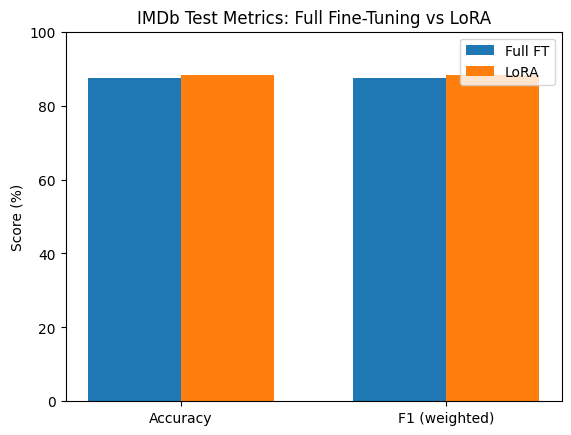

In [9]:
# ---------------------------------------------------------------
# STEP 9: Visualize Accuracy and F1 (TEST) for Full-FT vs LoRA.
# ---------------------------------------------------------------
labels = ["Accuracy", "F1 (weighted)"]
full_vals = [full_test["eval_accuracy"]*100, full_test["eval_f1"]*100]
lora_vals = [lora_test["eval_accuracy"]*100, lora_test["eval_f1"]*100]

x = np.arange(len(labels)); width = 0.35
fig, ax = plt.subplots()
ax.bar(x - width/2, full_vals, width, label="Full FT")
ax.bar(x + width/2, lora_vals, width, label="LoRA")
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylabel("Score (%)"); ax.set_ylim(0, 100)
ax.legend()
plt.title("IMDb Test Metrics: Full Fine-Tuning vs LoRA")
plt.show()

## 9.2 Confusion Matrices and Classification Reports

/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Full Fine-Tuning — Classification Report ===
              precision    recall  f1-score   support

    negative     0.9038    0.8438    0.8727       512
    positive     0.8467    0.9057    0.8752       488

    accuracy                         0.8740      1000
   macro avg     0.8753    0.8747    0.8740      1000
weighted avg     0.8759    0.8740    0.8740      1000



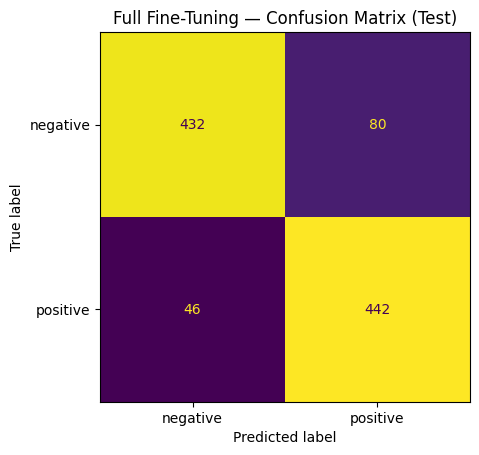

/Users/fongkangwei/nus/ay25_26/dsa4213/envs/transformer/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== LoRA — Classification Report ===
              precision    recall  f1-score   support

    negative     0.9089    0.8574    0.8824       512
    positive     0.8588    0.9098    0.8836       488

    accuracy                         0.8830      1000
   macro avg     0.8839    0.8836    0.8830      1000
weighted avg     0.8845    0.8830    0.8830      1000



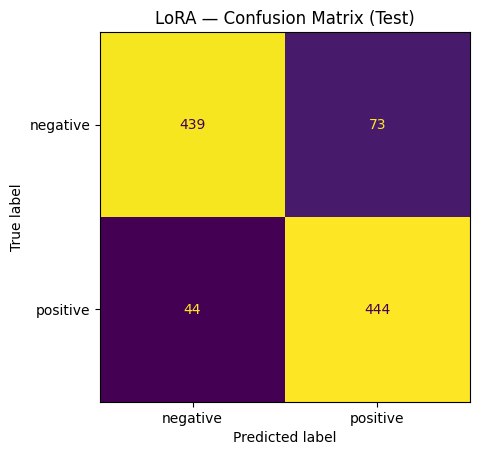

In [10]:
# ---------------------------------------------------------------
# STEP 10: Confusion matrices AND classification reports
# for both strategies on the TEST set.
# ---------------------------------------------------------------
def preds_for(trainer, split):
    pred_out = trainer.predict(split)
    y_true = pred_out.label_ids
    y_pred = np.argmax(pred_out.predictions, axis=1)
    return y_true, y_pred

def cm_and_report(y_true, y_pred, title):
    # Classification report (precision/recall/F1 per class)
    print(f"\n=== {title} — Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=["negative","positive"], digits=4))
    # Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["negative","positive"])
    fig, ax = plt.subplots()
    disp.plot(ax=ax, values_format="d", colorbar=False)
    plt.title(f"{title} — Confusion Matrix (Test)")
    plt.show()

# Full-FT
y_true_full, y_pred_full = preds_for(trainer_full_final, tokenized["test"])
cm_and_report(y_true_full, y_pred_full, "Full Fine-Tuning")

# LoRA
y_true_lora, y_pred_lora = preds_for(trainer_lora_final, tokenized["test"])
cm_and_report(y_true_lora, y_pred_lora, "LoRA")


## 9.3 Error Cases

In [11]:
# ---------------------------------------------------------------
# STEP 11: Show a few misclassified test examples for both models.
# ---------------------------------------------------------------

def show_misclassified(title, y_true, y_pred, dataset):
    """Print up to 10 misclassified reviews for inspection."""
    mis_idx = np.where(y_true != y_pred)[0][:10]
    print(f"\n=== {title} — {len(mis_idx)} Misclassified Samples ===")
    for i in mis_idx:
        review = dataset["test"][i]["text"]
        true_label = label_map[int(y_true[i])]
        pred_label = label_map[int(y_pred[i])]
        print(f"\nTrue={true_label} | Pred={pred_label}")
        print(review[:400].replace("\n"," "), "...\n")

# Misclassified for Full Fine-Tuning
show_misclassified("Full Fine-Tuning", y_true_full, y_pred_full, dataset)

# Misclassified for LoRA
show_misclassified("LoRA", y_true_lora, y_pred_lora, dataset)



=== Full Fine-Tuning — 10 Misclassified Samples ===

True=negative | Pred=positive
Coming from Kiarostami, this art-house visual and sound exposition is a surprise. For a director known for his narratives and keen observation of humans, especially children, this excursion into minimalist cinematography begs for questions: Why did he do it? Was it to keep him busy during a vacation at the shore? <br /><br />"Five, 5 Long Takes" consists of, you guessed it, five long takes. They a ...


True=negative | Pred=positive
Intended as light entertainment, this film is indeed successful as such during its first half, but then succumbs to a rapidly foundering script that drops it down. Harry (Judd Nelson), a "reformed" burglar, and Daphne (Gina Gershon), an aspiring actress, are employed as live window mannequins at a department store where one evening they are late in leaving and are locked within, whereupon they wit ...


True=negative | Pred=positive
"An astronaut (Michael Emmet) dies while r

## 9.4 Efficiency and Results Summary

,model,acc,f1,time_s,peak_mem_gb,peak_vram_gb,best_lr,best_bs,best_ep,f1_per_sec
0,Full-FT,0.874,0.873957,809.210654,0.566895,None,0.00002,16,2,0.001080
1,LoRA,0.883,0.882983,850.069254,0.455582,None,0.00050,16,3,0.001039


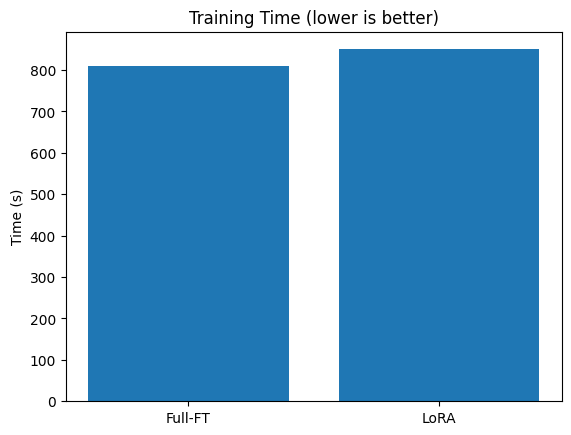

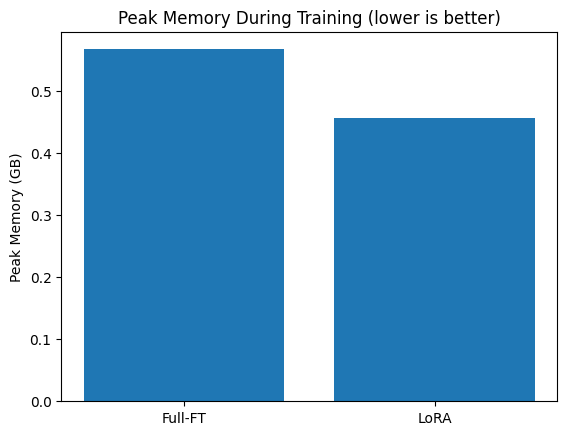

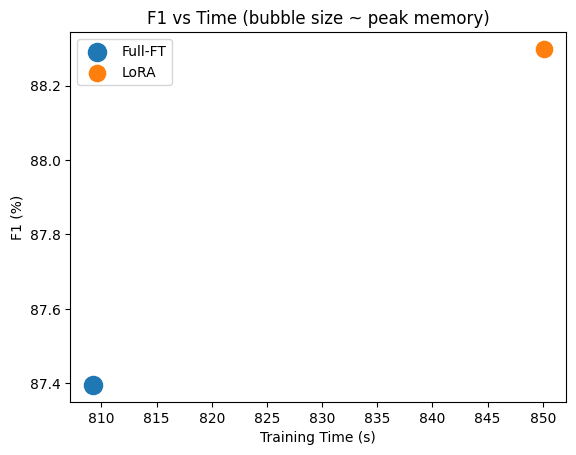

✅ Saved imdb_final_results.json
✅ Saved imdb_final_summary.csv


In [12]:
# ---------------------------------------------------------------
# STEP 12: Summarize efficiency & performance, plot, and save JSON.
# ---------------------------------------------------------------

# Build summary table (add peak memory + optional VRAM)
summary = pd.DataFrame([
    {
        "model": "Full-FT",
        "acc": full_test["eval_accuracy"],
        "f1": full_test["eval_f1"],
        "time_s": full_time_s,
        "peak_mem_gb": full_mem_gb,
        "peak_vram_gb": full_vram_gb if 'full_vram_gb' in globals() else None,
        "best_lr": float(best_full["lr"]),
        "best_bs": int(best_full["bs"]),
        "best_ep": int(best_full["ep"]),
    },
    {
        "model": "LoRA",
        "acc": lora_test["eval_accuracy"],
        "f1": lora_test["eval_f1"],
        "time_s": lora_time_s,
        "peak_mem_gb": lora_mem_gb,
        "peak_vram_gb": lora_vram_gb if 'lora_vram_gb' in globals() else None,
        "best_lr": float(best_lora["lr"]),
        "best_bs": int(best_lora["bs"]),
        "best_ep": int(best_lora["ep"]),
    },
])
summary["f1_per_sec"] = summary["f1"] / summary["time_s"]
display(summary)

# -----------------------------
# Efficiency comparison plots
# -----------------------------
models = summary["model"].tolist()

# 1) Training Time (s)
fig, ax = plt.subplots()
ax.bar(models, summary["time_s"].values)
ax.set_ylabel("Time (s)")
ax.set_title("Training Time (lower is better)")
plt.show()

# 2) Peak Memory (GB)
fig, ax = plt.subplots()
ax.bar(models, summary["peak_mem_gb"].values)
ax.set_ylabel("Peak Memory (GB)")
ax.set_title("Peak Memory During Training (lower is better)")
plt.show()

# 3) F1 vs Time scatter (bubble size ~ peak memory GB)
fig, ax = plt.subplots()
for _, row in summary.iterrows():
    ax.scatter(row["time_s"], row["f1"]*100, s=300*max(row["peak_mem_gb"], 1e-6), label=row["model"])
ax.set_xlabel("Training Time (s)")
ax.set_ylabel("F1 (%)")
ax.set_title("F1 vs Time (bubble size ~ peak memory)")
# avoid duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
plt.show()

# -----------------------------
# Save JSON
# -----------------------------
final = {
    "Full_FT": {
        "test_metrics": full_test,
        "train_time_s": float(full_time_s),
        "peak_mem_gb": float(full_mem_gb),
        "peak_vram_gb": (float(full_vram_gb) if ('full_vram_gb' in globals() and full_vram_gb is not None) else None),
        "best_params": {"lr": float(best_full["lr"]), "bs": int(best_full["bs"]), "ep": int(best_full["ep"])},
    },
    "LoRA": {
        "test_metrics": lora_test,
        "train_time_s": float(lora_time_s),
        "peak_mem_gb": float(lora_mem_gb),
        "peak_vram_gb": (float(lora_vram_gb) if ('lora_vram_gb' in globals() and lora_vram_gb is not None) else None),
        "best_params": {"lr": float(best_lora["lr"]), "bs": int(best_lora["bs"]), "ep": int(best_lora["ep"])},
    },
}

with open("imdb_final_results.json", "w") as f:
    json.dump(final, f, indent=2)
print("✅ Saved imdb_final_results.json")

summary.to_csv("imdb_final_summary.csv", index=False)
print("✅ Saved imdb_final_summary.csv")